In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
import datetime
from copy import deepcopy
import mlflow
import random
import logging
import joblib
from scipy.fft import rfft

mlflow.set_tracking_uri(uri='http://192.168.0.174:8080')
mlflow.set_experiment('Gearbox Speed Estimation')
logging.getLogger('mlflow.utils.requirements_utils').setLevel(logging.ERROR)
logging.getLogger('mlflow.store.model_registry.abstract_store').setLevel(logging.ERROR)
cur_dir = os.getcwd()
device = 'cuda'
torch.use_deterministic_algorithms(True) 

### Sets preparation

In [2]:
df_freq = pd.read_csv(cur_dir + '//data//df_freq.csv')  # real samples
df_synth = pd.read_csv(cur_dir + '//data//df_synthetic_samples.csv')  # synthetic samples

There are two available data sets: real spectrums and synthetic spectrums, that are based on real ones. A model, trained on synthetic set and tested on real
set will overfit due to increased data leakage. To overcome this problem, synthetic samples based on some runs will be excluded, and corresponding real samples will be moved to validation set. Thus there will be train set from synthetic samples, test set from real samples that were used for train set creation and validation set from 100% unseen samples.<br/> 
Validation set will contain 3 real runs of 3 different speeds. These runs are selected based on spectrum similarity with any other run, as taking a run with unique spectrum will reduce model performance.<br/>
Test set will have all real runs, except those selected for validation.<br/>
Train set will contain synthetic data, based on runs from test set. Also samples with speeds within range 3 from origin speed(peak window size) will be excluded.

In [3]:
speed_lst = sorted(df_freq['speed'].unique())

X_train = df_synth[(df_synth['speed'] < df_synth['origin']-3) |  # removing speeds within real samples peak window
                   (df_synth['speed'] > df_synth['origin']+3)]  
# removing samples, used for validation
X_train = X_train[~((X_train['origin'] == speed_lst[0]) & (X_train['fault'] == 'Root crack') & (X_train['load'] == 0)) &
                  ~((X_train['origin'] == 25) & (X_train['fault'] == 'eccentricity') & (X_train['load'] == 0)) &
                  ~((X_train['origin'] == 40) & (X_train['fault'] == 'Root crack') & (X_train['load'] == 80))]

y_train = X_train['speed']
X_train = X_train.drop(columns=['speed', 'load', 'fault', 'origin'])
# removing samples, used for validation
df_test = df_freq[~((df_freq['speed'] == speed_lst[0]) & (df_freq['fault'] == 'Root crack') & (df_freq['load'] == 0)) &
                  ~((df_freq['speed'] == 25) & (df_freq['fault'] == 'eccentricity') & (df_freq['load'] == 0)) &
                  ~((df_freq['speed'] == 40) & (df_freq['fault'] == 'Root crack') & (df_freq['load'] == 80))]

X_test = df_test.drop(columns=['speed', 'load', 'fault', 'window_start'])
y_test = df_test['speed']
# selecting validation samples
df_validation = df_freq[((df_freq['speed'] == speed_lst[0]) & (df_freq['fault'] == 'Root crack') & 
                         (df_freq['load'] == 0)) |
                        ((df_freq['speed'] == 25) & (df_freq['fault'] == 'eccentricity') & (df_freq['load'] == 0)) |
                        ((df_freq['speed'] == 40) & (df_freq['fault'] == 'Root crack') & (df_freq['load'] == 80))]

X_validation = df_validation.drop(columns=['speed', 'load', 'fault', 'window_start'])
y_validation = df_validation['speed']

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('X_validation shape:', X_validation.shape)
print('Speeds in validation set:', df_validation['speed'].unique())
print('Faults in validation set:', df_validation['fault'].unique())

X_train shape: (360360, 230)
X_test shape: (4158, 230)
X_validation shape: (378, 230)
Speeds in validation set: [ 8.332031 25.       40.      ]
Faults in validation set: ['Root crack' 'eccentricity']


Scaling data before tensors creation.

In [4]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_validation = ss.transform(X_validation)

joblib.dump(ss, 'scaler.pkl')  # saving scaler for future use

['scaler.pkl']

Models, using 2d convolution layer are expected to perform better on the data, so tensors should have proper shape.<br/>
Amount of GPU memory is enough to store all thensors in it, so tensors are put to gpu from the beginning. As the tensors are in GPU memory, only train set needs a dataloader wrapper.

In [5]:
X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)  # GPU memory amount allows keeping all samples
X_train_t = torch.stack([X_train_t[:, :115], X_train_t[:, 115:]], dim=1)  # making image-like structure for conv2d
X_train_t = X_train_t.view(X_train_t.shape[0], 1, 2, 115)  # setting proper input shape
y_train_t = torch.from_numpy(y_train.values.astype(np.float32)).to(device)

train_dataset = TensorDataset(X_train_t, y_train_t)

X_test_t = torch.from_numpy(X_test.astype(np.float32)).to(device)
X_test_t = torch.stack([X_test_t[:, :115], X_test_t[:, 115:]], dim=1)
X_test_t = X_test_t.view(X_test_t.shape[0], 1, 2, 115)
y_test_t = torch.from_numpy(y_test.values.astype(np.float32)).to(device)

test_dataset = TensorDataset(X_test_t, y_test_t)

X_validation_t = torch.from_numpy(X_validation.astype(np.float32)).to(device)
X_validation_t = torch.stack([X_validation_t[:, :115], X_validation_t[:, 115:]], dim=1)
X_validation_t = X_validation_t.view(X_validation_t.shape[0], 1, 2, 115)
y_validation_t = torch.from_numpy(y_validation.values.astype(np.float32)).to(device)

validation_dataset = TensorDataset(X_validation_t, y_validation_t)
# small batch size was salected by trial and error. Bigger numbers lower learning results
train_dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True)  

### Instruments definition

Model class contains basic functionality and run name for saving in MLFlow.

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers, run_series=None):
        super().__init__()
        self.layers = layers
        self.run_series = run_series  # run name for initial train and retrains

    def forward(self, x):   
        return self.layers(x)

Early stop is used as the only way for training to stop. The class saves the best(ignoring threshold) model state and waits for a number(patience) of epochs
 with loss improvements below threshold(delta).

In [7]:
class EarlyStop:
    def __init__(self, patience, delta):
        self.patience = patience  # amount of epochs without improvements before early stop
        self.delta = delta  # threshold for an improvement in loss
        self.best_loss = float('inf')  # loss for stop decision making
        self.no_improve = 0  # epochs without improvements counter
        self.best_model_state = None
        self.best_model_state_loss = float('inf')  # loss of best_model_state

    def __call__(self, loss, model):
        if loss < self.best_model_state_loss:  # saving model state in case of any improvement
            self.best_model_state = deepcopy(model.state_dict())  
            self.best_model_state_loss = loss
            
        if loss >= self.best_loss - self.delta:  # no significant improvement
            self.no_improve += 1
            if self.no_improve >= self.patience:
                model.load_state_dict(self.best_model_state)
                return True
        else:  # there was an improvement
            self.best_loss = loss
            self.no_improve = 0
            
        return False

Basic training function. manual_seed is used for reproducibility.

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    
    for X, y in dataloader:    
        torch.manual_seed(42)
        optimizer.zero_grad(set_to_none=True)        
        pred = model(X).flatten()
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

Basic test function. As all used tensors are stored in GPU memory, there's no batching.

In [9]:
def test(dataset, model, loss_fn):
    model.eval()
    
    with torch.no_grad():  # here full tensors are used to save some time
        pred = model(dataset.tensors[0]).flatten()
        loss = loss_fn(pred, dataset.tensors[1]).item()
        
    return loss

Training_model function trains and retrains models, logging metrics for each epoch.<br/>
MSELoss was chosen as loss function to maximize loss for significantly wrong prediction.<br/>
AdamW is used as optimizer to allow weights penalty.<br/>
LinearLR is used as learning rate scheduler to adjust learning rate for single experiment.

In [10]:
def train_model(patience, delta, lr, end_factor, total_iters, weight_decay, layers=None, model=None, run_series=None):
    mlflow.end_run()  # in case previous training was interrupted
    torch.cuda.empty_cache()
    
    if not model:
        torch.manual_seed(42)        
        model = NeuralNetwork(layers, run_series).to(device)  

    early_stop = EarlyStop(patience, delta)
    loss_fn = nn.MSELoss()  # this loss was chosen because of sensitivity to big individual losses
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, fused=True)
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=end_factor, total_iters=total_iters)
    
    cur_run_name = model.run_series + '_' + \
                    str(mlflow.search_runs(filter_string=f'tag.mlflow.runName LIKE "{model.run_series}_%"').shape[0] + 1)
                                       
    mlflow.start_run(run_name=cur_run_name)
    mlflow.set_tag('layers', model.layers) 
    mlflow.log_params({'patience' : patience,
                      'delta' : delta,
                      'lr': lr,
                      'end_factor' : end_factor, 
                      'total_iters' : total_iters,
                      'weight_decay' : weight_decay})    

    print('Training')
    e = 0    
    test_loss = float('inf')

    if not run_series:  # saving initial scores for model retraining
        test_loss = test(test_dataset, model, loss_fn)
        train_loss = test(train_dataset, model, loss_fn)
        mlflow.log_metrics({'train_loss': train_loss,
                            'test_loss': test_loss}, 
                           step=-1,
                           synchronous=False) 
    
    while not early_stop(test_loss, model):  # training until early stop
        e += 1
        train(train_dataloader, model, loss_fn, optimizer)
        
        train_loss = test(train_dataset, model, loss_fn)
        test_loss = test(test_dataset, model, loss_fn)  
         
        mlflow.log_metrics({'train_loss': train_loss,
                            'test_loss': test_loss}, 
                           step=e,
                           synchronous=False) 
        #print(datetime.datetime.now(), '\t', e, '\t', test_loss, '\t', train_loss)
       
        scheduler.step()
    
    train_loss = test(train_dataset, model, loss_fn)
    test_loss = test(test_dataset, model, loss_fn)
     
    mlflow.log_metrics({'train_loss': train_loss,
                        'test_loss': test_loss}, 
                        step=e+1,  # to display best results as last metrics
                        synchronous=False)
    
    print('Test loss:', test_loss)
    print('Train loss:', train_loss)
    print('Epochs:', e)

    signature = mlflow.models.infer_signature(train_dataset.tensors[0].cpu().numpy(), 
                                              train_dataset.tensors[1].cpu().numpy())
    mlflow.pytorch.log_model(pytorch_model=model, 
                             artifact_path='model',
                             registered_model_name=cur_run_name,
                             signature=signature)
    mlflow.end_run()
    
    return model

### Model training

##### Baseline 

Linear regression is used as the simplest solution to compare with other models.

In [11]:
lr = LinearRegression(n_jobs=10)
lr.fit(X_train, y_train)
print('Train MSE:', mean_squared_error(y_train, lr.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, lr.predict(X_test)))
print('Validation MSE:', mean_squared_error(y_validation, lr.predict(X_validation)))

Train MSE: 61.90892280647876
Test MSE: 143.88577123259594
Validation MSE: 87.2758115252751


##### Search for architecture

Several experiment serieses were performed before this one, but only this one is shown as the one with best results.<br/>
During previous experiment serieses various test sets(not documented) were tested, leading to the identification of optimal learning parameters.</br>
Changes to layers configuration are described in comments to the code. These comments describe how  the model was expected to work, but it can do everything it's own way)

In [13]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 1, kernel_size=(2, 15), padding=(0, 7)),  # detects peaks, outputs values close to 1
                        nn.ReLU(),  # removes negative values(no peaks)                   
                        nn.Linear(115, 1)  # multiplies detected peak by corresponding speed value
                    )  
model = train_model(patience=10, delta=1, lr=1e-3, end_factor=0.8, total_iters=20, weight_decay=0, layers=layers, 
                    run_series='conv2d')

Training
Test loss: 67.00157928466797
Train loss: 57.0078010559082
Epochs: 25


Successfully registered model 'conv2d_1'.
Created version '1' of model 'conv2d_1'.


🏃 View run conv2d_1 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/371e061dad44428db77f978bb5d422b4
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


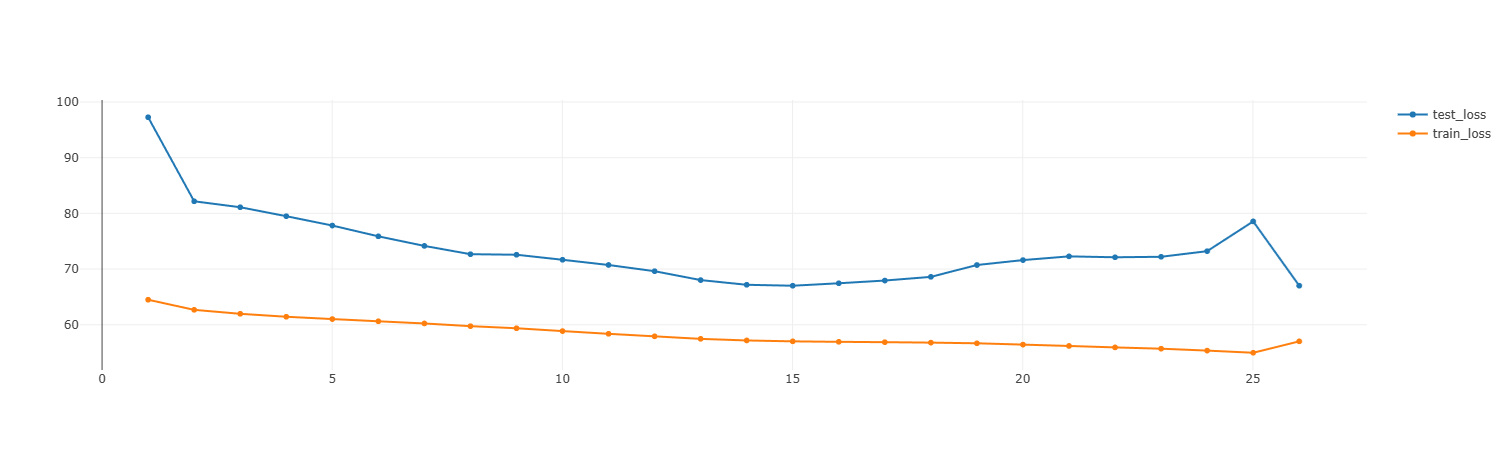

In [14]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),  # channels store peaks configurations
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)),  # summing up all channels
                        nn.Linear(115, 1)
                    )  
model = train_model(patience=10, delta=1, lr=1e-3, end_factor=0.8, total_iters=20, weight_decay=0, layers=layers, 
                    run_series='conv2d')

Training
Test loss: 23.536603927612305
Train loss: 8.298240661621094
Epochs: 24


Successfully registered model 'conv2d_2'.
Created version '1' of model 'conv2d_2'.


🏃 View run conv2d_2 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/6f74b042f4b2471c9234df1cecb3fb91
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


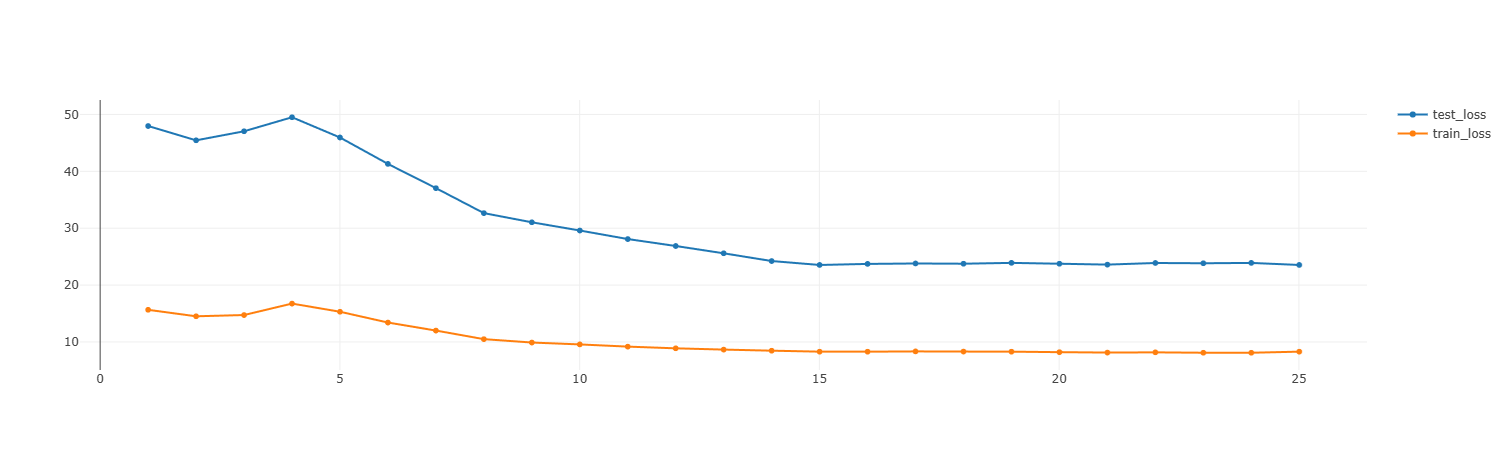

This model already outperforms linear regression.

In [15]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),  # adding more non-linearity to detected peaks post-processing 
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=10, delta=1, lr=1e-3, end_factor=0.8, total_iters=20, weight_decay=0, layers=layers, 
                    run_series='conv2d')

Training
Test loss: 6.859555721282959
Train loss: 0.44520455598831177
Epochs: 31


Successfully registered model 'conv2d_3'.
Created version '1' of model 'conv2d_3'.


🏃 View run conv2d_3 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/b4fc8de34d8743429fc3fdb52d204f98
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


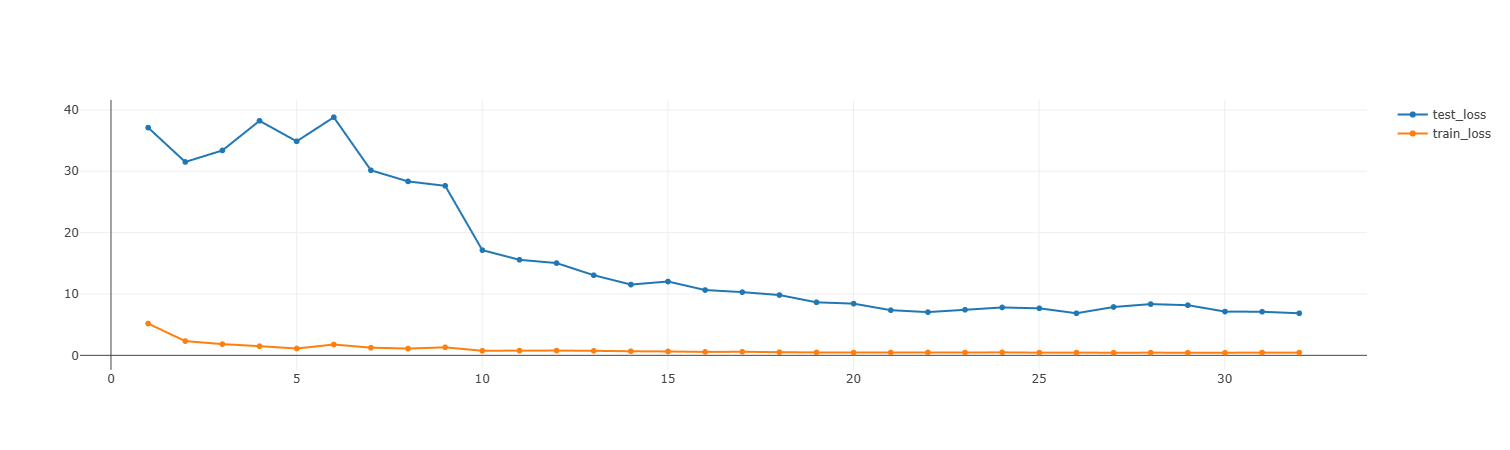

In [16]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Dropout(0.01),  # will this increase the ressult?
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=10, delta=1, lr=1e-3, end_factor=0.8, total_iters=20, weight_decay=0, layers=layers, 
                    run_series='conv2d')

Training
Test loss: 14.405359268188477
Train loss: 0.9731745719909668
Epochs: 16


Successfully registered model 'conv2d_4'.
Created version '1' of model 'conv2d_4'.


🏃 View run conv2d_4 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/f080c1419fff4f21abb25e485d129c3f
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


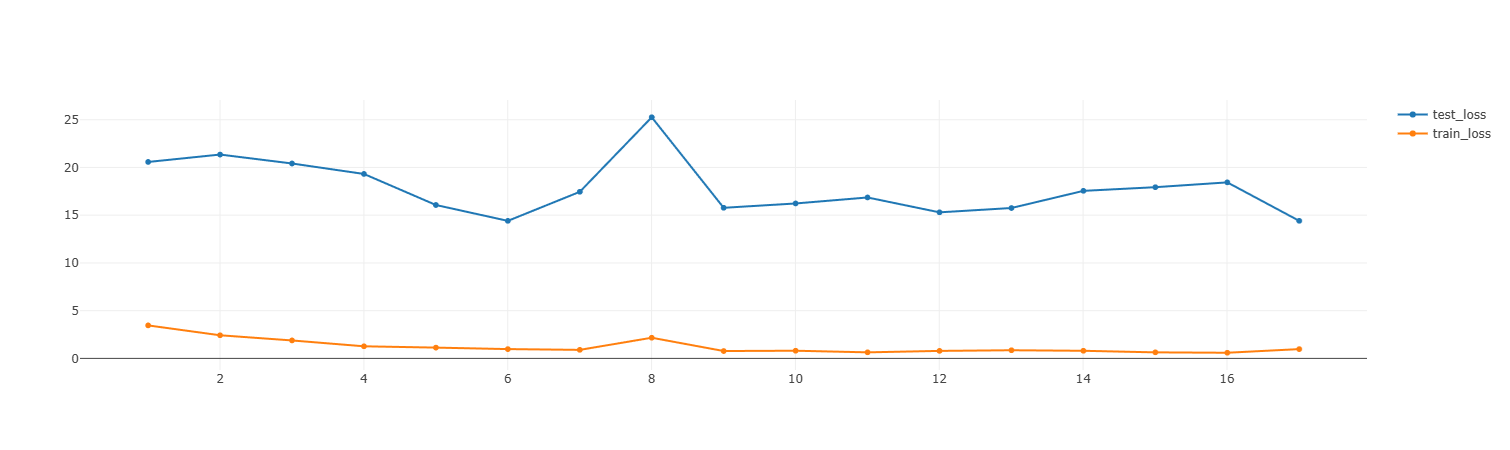

In [17]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.BatchNorm2d(33),  # will this increase the ressult?
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=10, delta=1, lr=1e-3, end_factor=0.8, total_iters=20, weight_decay=0, layers=layers, 
                    run_series='conv2d')

Training
Test loss: 19.16558837890625
Train loss: 0.3851555585861206
Epochs: 34
🏃 View run conv2d_5 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/c5a9ff4133294bcd8c3eb0b019b44b8c
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


Successfully registered model 'conv2d_5'.
Created version '1' of model 'conv2d_5'.


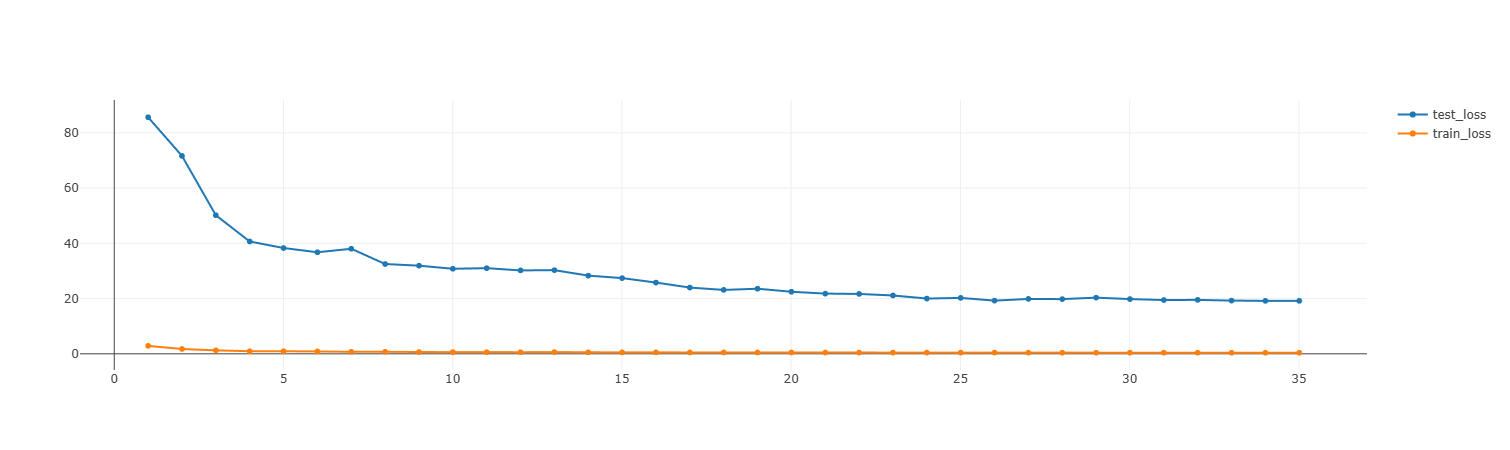

In [18]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.ReLU(),  # another relu can add more filtering to detected peaks
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=10, delta=1, lr=1e-3, end_factor=0.8, total_iters=20, weight_decay=0, layers=layers, 
                    run_series='conv2d')

Training
Test loss: 15.212262153625488
Train loss: 0.3595876395702362
Epochs: 48


Successfully registered model 'conv2d_6'.
Created version '1' of model 'conv2d_6'.


🏃 View run conv2d_6 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/bb89389395b24219838a144189f51c67
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


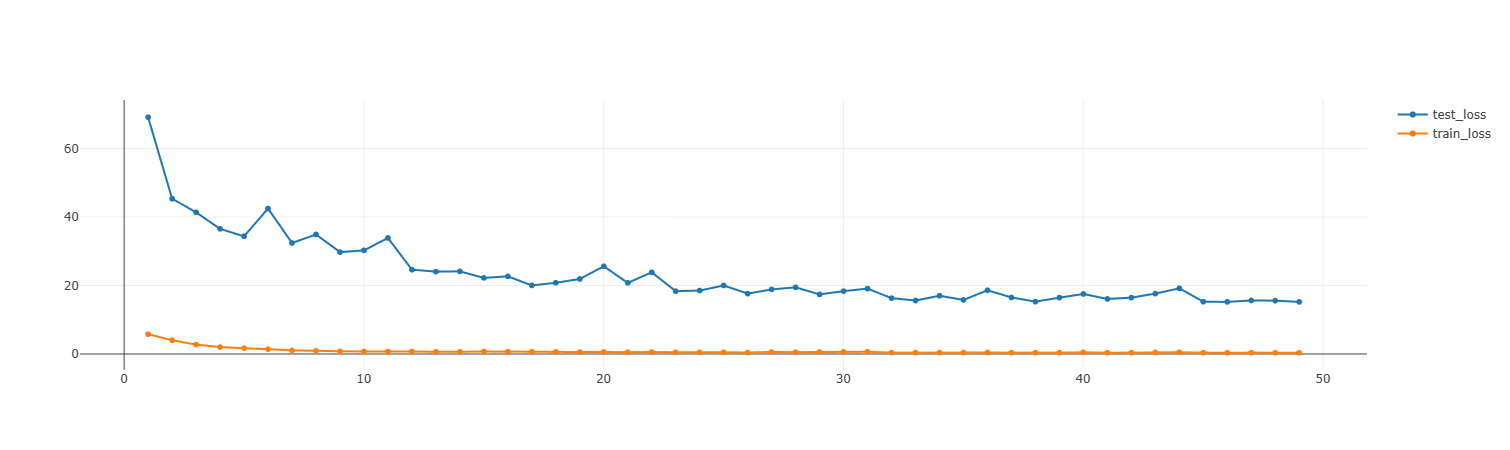

In [19]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),
                        nn.ReLU(),
                        nn.Linear(55, 25),  # increasing calculations amount on peaks values    
                        nn.ReLU(),
                        nn.Linear(25, 1)
                    )  
model = train_model(patience=10, delta=1, lr=1e-3, end_factor=0.8, total_iters=20, weight_decay=0, layers=layers, 
                    run_series='conv2d')

Training
Test loss: 14.326704978942871
Train loss: 0.18333211541175842
Epochs: 25


Successfully registered model 'conv2d_7'.
Created version '1' of model 'conv2d_7'.


🏃 View run conv2d_7 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/000d9fd1516f41ebb335b90dac6311c9
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


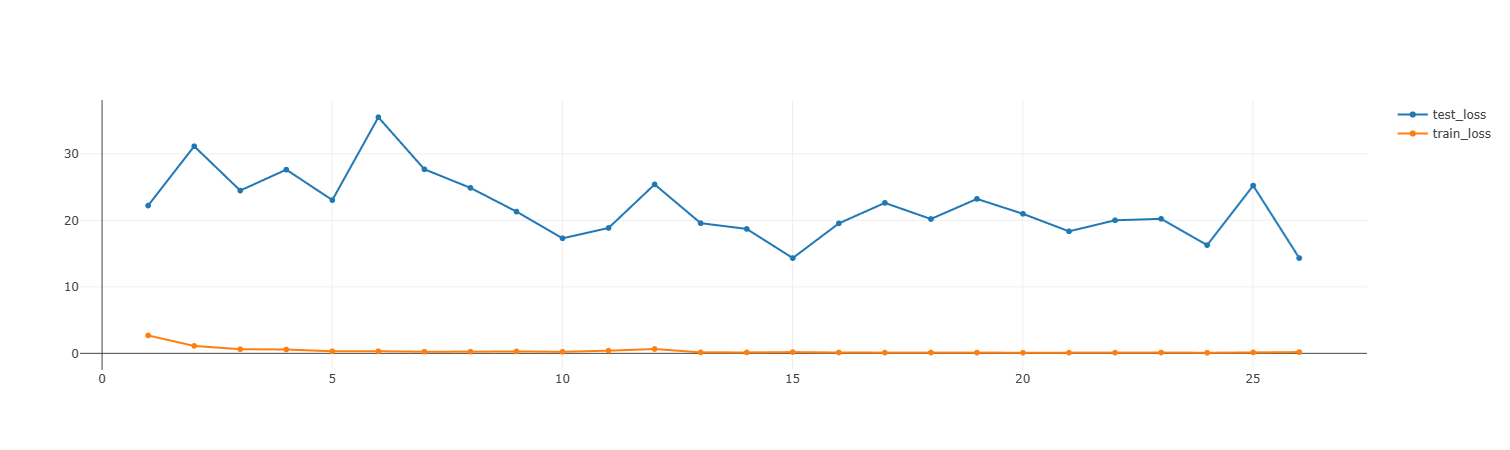

The best model so far is the model from run conv2d_3 with MSE 6.8596. This is much better than MSE 143 provided by linear regression, so we are on the right way.<br/>
Learning curvers show signs of unrepresentative test set, which in this case is ok: peak-speed configurations are different in train and test sets, but a model that learns to properly detect speed on test set should do the same on test set.

##### Tuning architecture

Architecture from run conv2d_3 is taken for tuning layers parameters without changing layer configuration. Resources for each experiment are increased to provide better changes evaluation.<br/>
How will perform the best architecture with increased resources?

In [20]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 3.4754903316497803
Train loss: 0.23546189069747925
Epochs: 157


Successfully registered model 'conv2d_tune_1'.
Created version '1' of model 'conv2d_tune_1'.


🏃 View run conv2d_tune_1 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/9872e254b7c64bfcab4ed605798fe24e
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


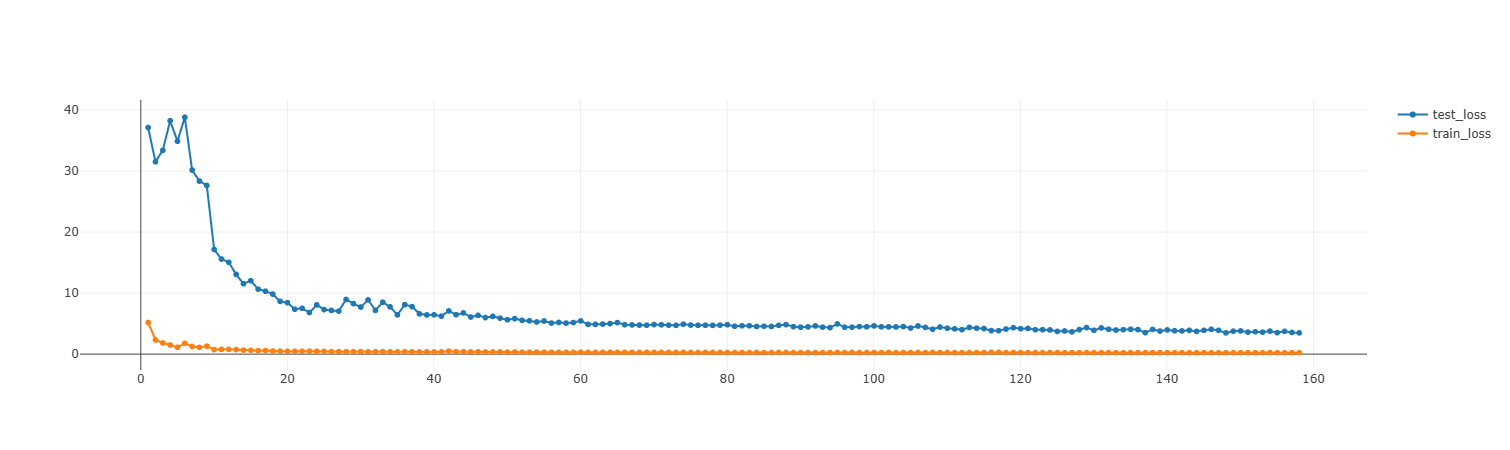

In [21]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 36, kernel_size=(2, 15), padding=(0, 7)),  # storisg more peak configurations
                        nn.ReLU(),
                        nn.Conv2d(36, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 9.715721130371094
Train loss: 0.24213185906410217
Epochs: 68


Successfully registered model 'conv2d_tune_2'.
Created version '1' of model 'conv2d_tune_2'.


🏃 View run conv2d_tune_2 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/164d3810756640b9b11390a66622268b
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


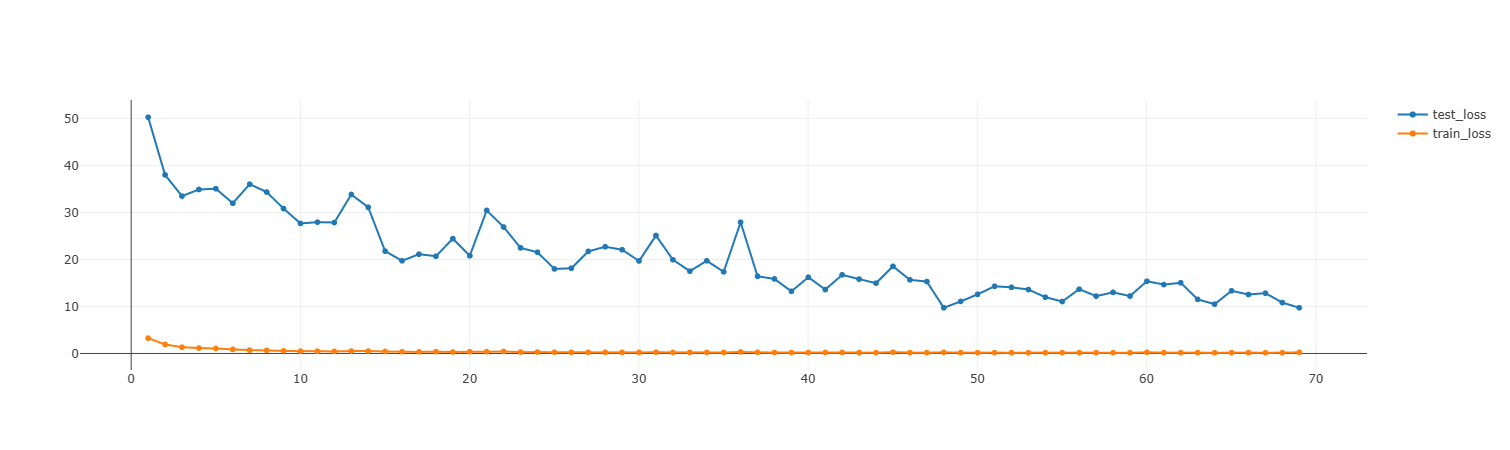

In [22]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 30, kernel_size=(2, 15), padding=(0, 7)),  # improving generalisation
                        nn.ReLU(),
                        nn.Conv2d(30, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 40.985721588134766
Train loss: 1.6832666397094727
Epochs: 24


Successfully registered model 'conv2d_tune_3'.
Created version '1' of model 'conv2d_tune_3'.


🏃 View run conv2d_tune_3 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/702d1e5303fa416aa8bb310f63659c1d
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


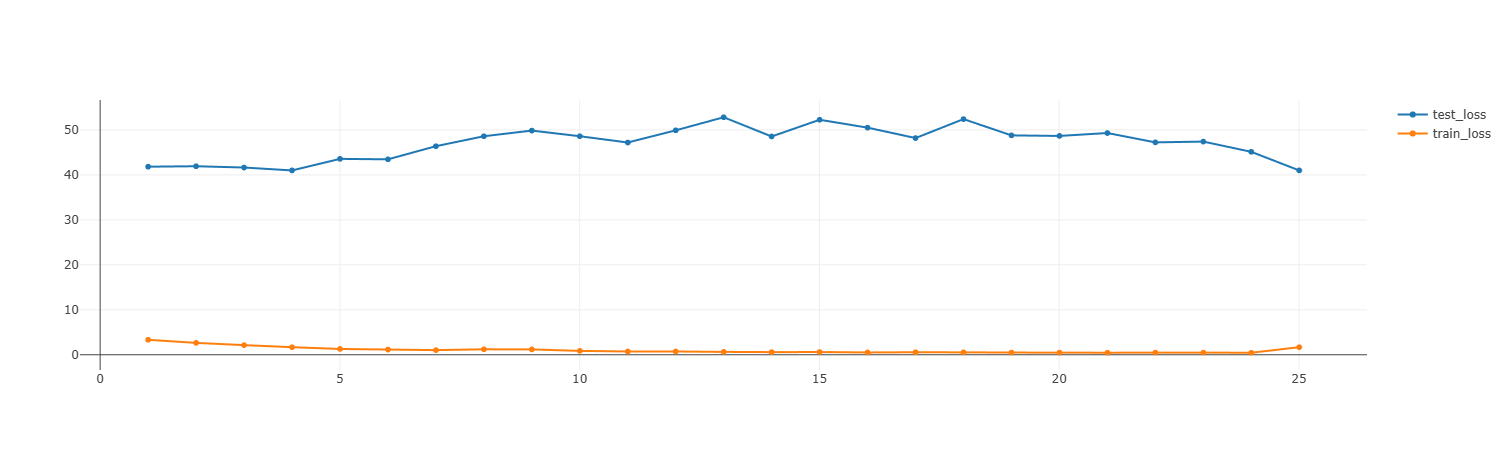

In [23]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 9), padding=(0, 4)),  # changing perak window size
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 25.87464714050293
Train loss: 0.3324284255504608
Epochs: 131


Successfully registered model 'conv2d_tune_4'.
Created version '1' of model 'conv2d_tune_4'.


🏃 View run conv2d_tune_4 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/0dd25ee186204bf3ade09236ef79f675
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


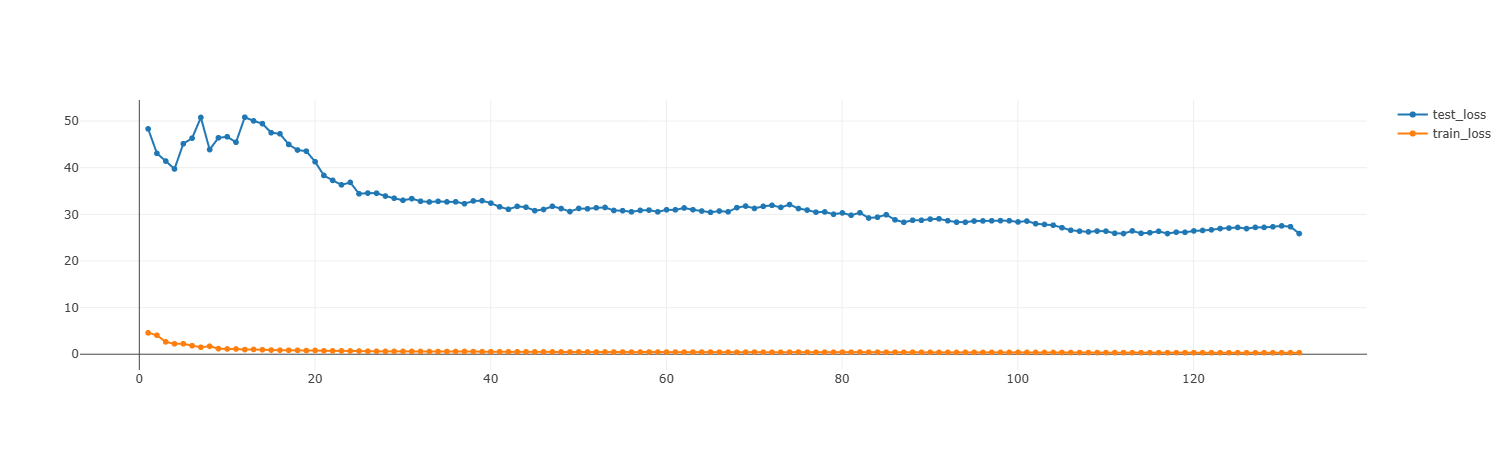

In [24]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 21), padding=(0, 10)),  # changing perak window size
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 28.4500732421875
Train loss: 0.4855867922306061
Epochs: 35
🏃 View run conv2d_tune_5 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/d34991dd753e4d9699d48194c468b625
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


Successfully registered model 'conv2d_tune_5'.
Created version '1' of model 'conv2d_tune_5'.


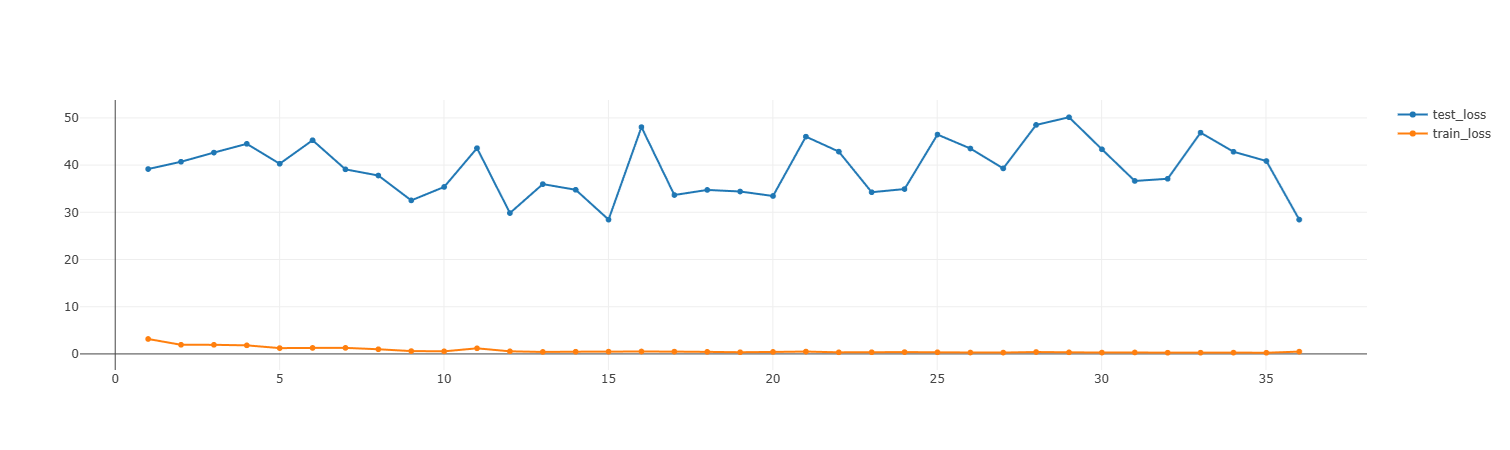

In [25]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 5), padding=(0, 2)),  # enabling 2nd level features
                        nn.Linear(115, 55),   
                        nn.ReLU(),
                        nn.Linear(55, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 16.021059036254883
Train loss: 0.414469450712204
Epochs: 35


Successfully registered model 'conv2d_tune_6'.
Created version '1' of model 'conv2d_tune_6'.


🏃 View run conv2d_tune_6 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/b4f0cd1db4ce42dab11a52d93683a7c1
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


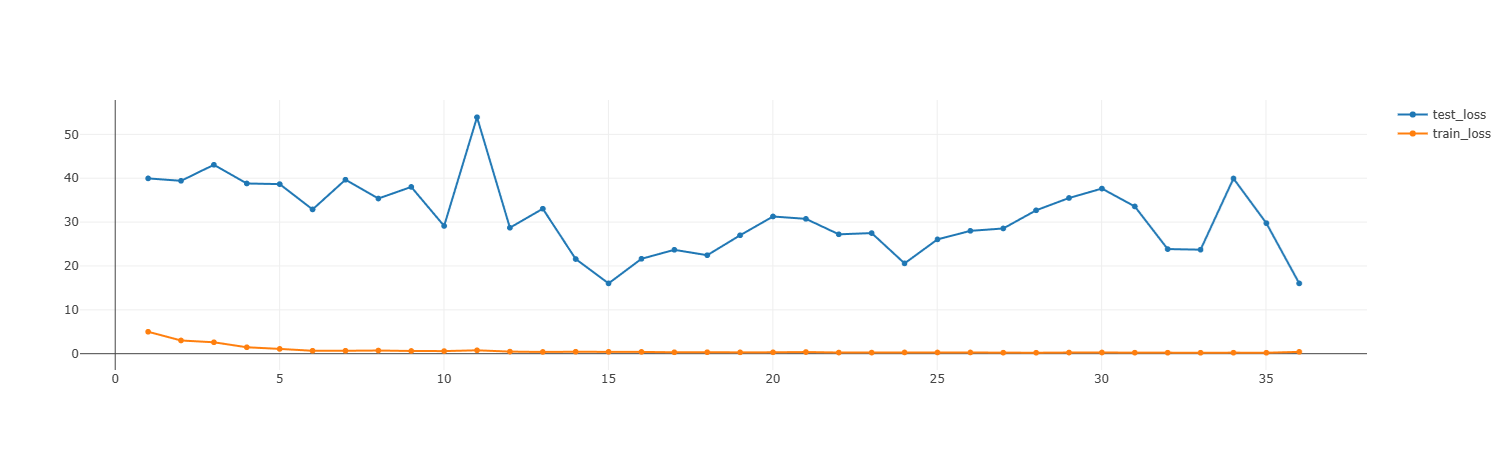

In [26]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 40),  # looking for best layer size  
                        nn.ReLU(),
                        nn.Linear(40, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 1.16567063331604
Train loss: 0.2065172642469406
Epochs: 66


Successfully registered model 'conv2d_tune_7'.
Created version '1' of model 'conv2d_tune_7'.


🏃 View run conv2d_tune_7 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/f4ccaa73626440f1b4cb5ce90aff9b21
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


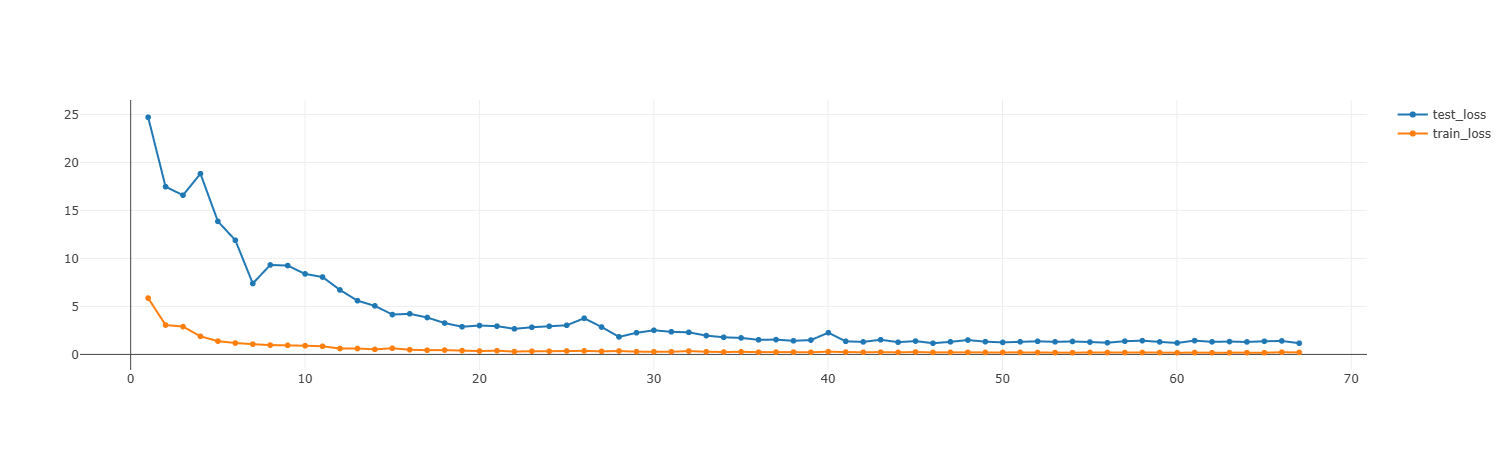

In [27]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 70),  # looking for best layer size     
                        nn.ReLU(),
                        nn.Linear(70, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 3.2847588062286377
Train loss: 0.19629105925559998
Epochs: 160


Successfully registered model 'conv2d_tune_8'.
Created version '1' of model 'conv2d_tune_8'.


🏃 View run conv2d_tune_8 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/04cf788ad18d45529b0107d025605c25
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


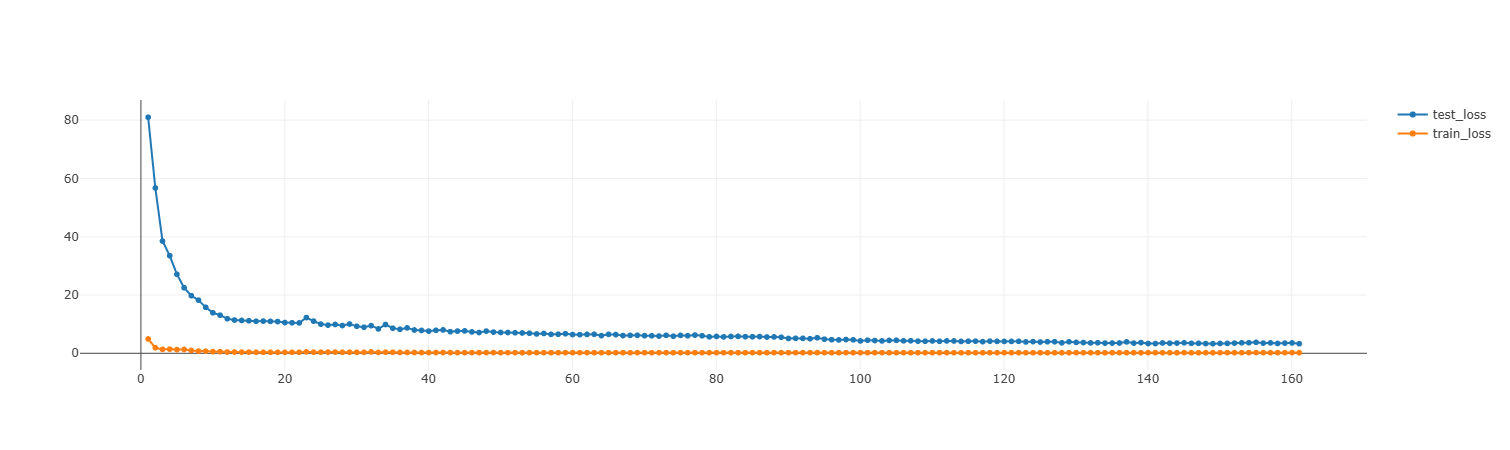

In [28]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 30),  # looking for best layer size     
                        nn.ReLU(),
                        nn.Linear(30, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=0, layers=layers, 
                    run_series='conv2d_tune')

Training
Test loss: 17.81951332092285
Train loss: 0.8079138398170471
Epochs: 62


Successfully registered model 'conv2d_tune_9'.
Created version '1' of model 'conv2d_tune_9'.


🏃 View run conv2d_tune_9 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/aca690d586634b15962a2487e21c566e
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


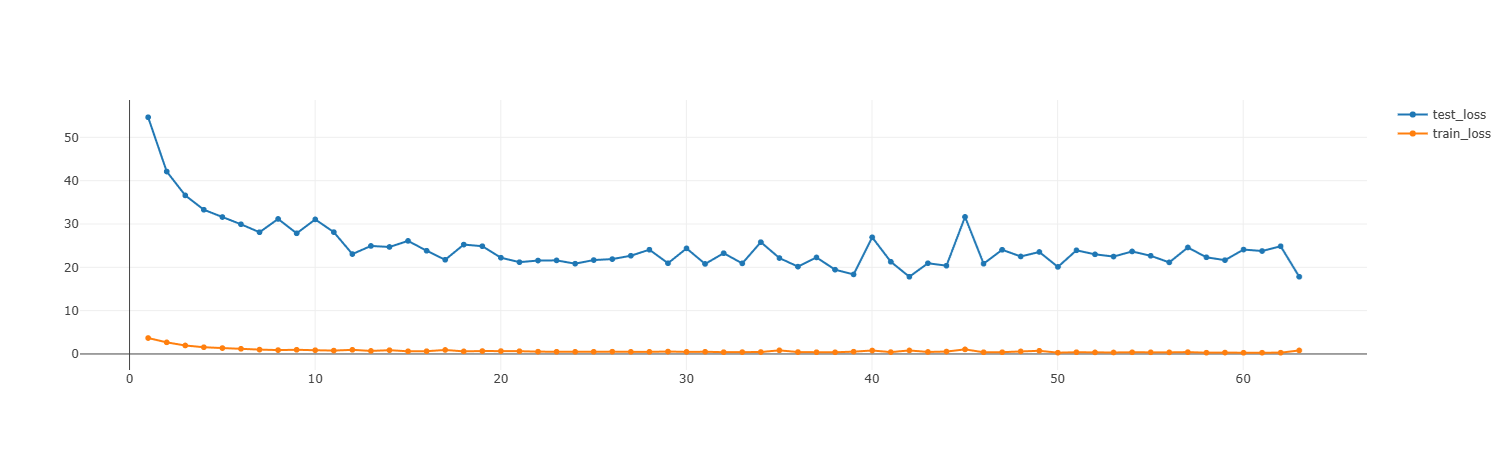

Run conv2d_tune_7 achieved best results with MSE 1.1657.

##### Tuning best model

Best performing model from previus section is taken for fine tuning. At first weight_decay should be tuned.

In [29]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 40),   
                        nn.ReLU(),
                        nn.Linear(40, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=1e-6, layers=layers, 
                    run_series='conv2d_final')

Training
Test loss: 1.16567063331604
Train loss: 0.2065172642469406
Epochs: 66


Successfully registered model 'conv2d_final_1'.
Created version '1' of model 'conv2d_final_1'.


🏃 View run conv2d_final_1 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/f872a0acabc74ad18c3cf7a73e3507da
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


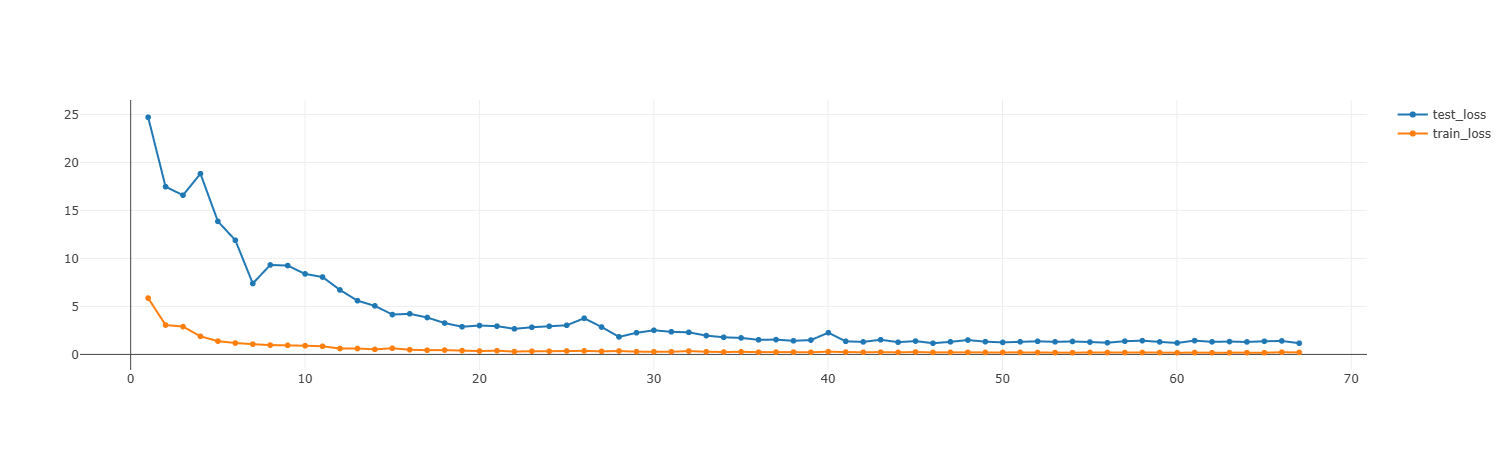

In [30]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 40),   
                        nn.ReLU(),
                        nn.Linear(40, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=1e-3, layers=layers, 
                    run_series='conv2d_final')

Training
Test loss: 1.033373236656189
Train loss: 0.17262808978557587
Epochs: 127


Successfully registered model 'conv2d_final_2'.
Created version '1' of model 'conv2d_final_2'.


🏃 View run conv2d_final_2 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/2e5ee51aea684c558b7691604fe2f256
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


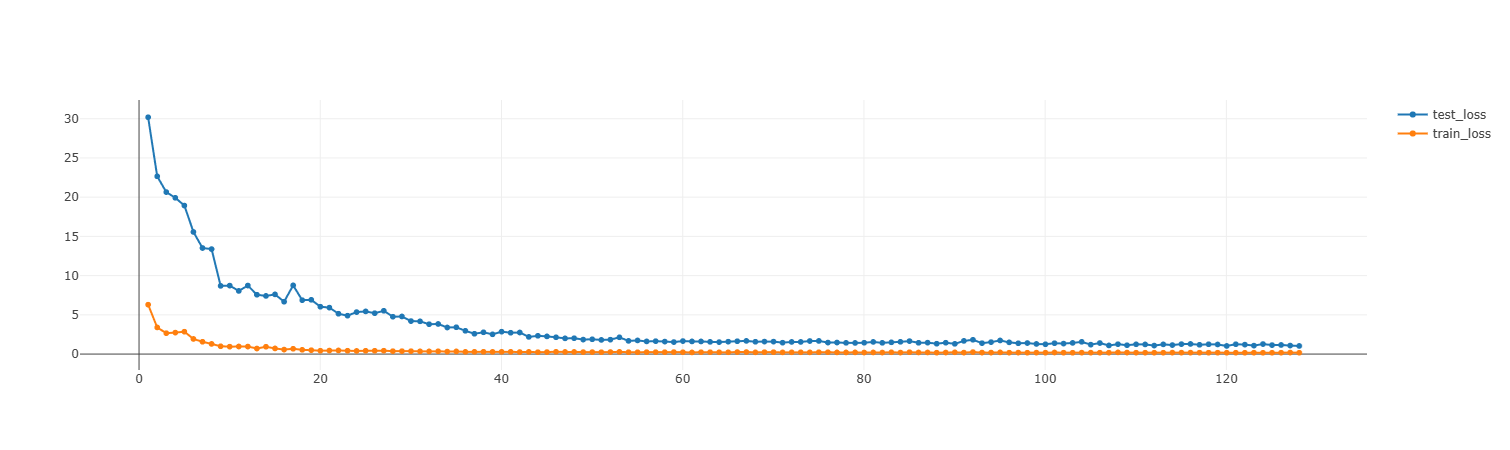

In [31]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 40),   
                        nn.ReLU(),
                        nn.Linear(40, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=1e-4, layers=layers, 
                    run_series='conv2d_final')

Training
Test loss: 0.9857057332992554
Train loss: 0.21782374382019043
Epochs: 76


Successfully registered model 'conv2d_final_3'.
Created version '1' of model 'conv2d_final_3'.


🏃 View run conv2d_final_3 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/dad8865c7f894b22aa353ef5a9205313
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


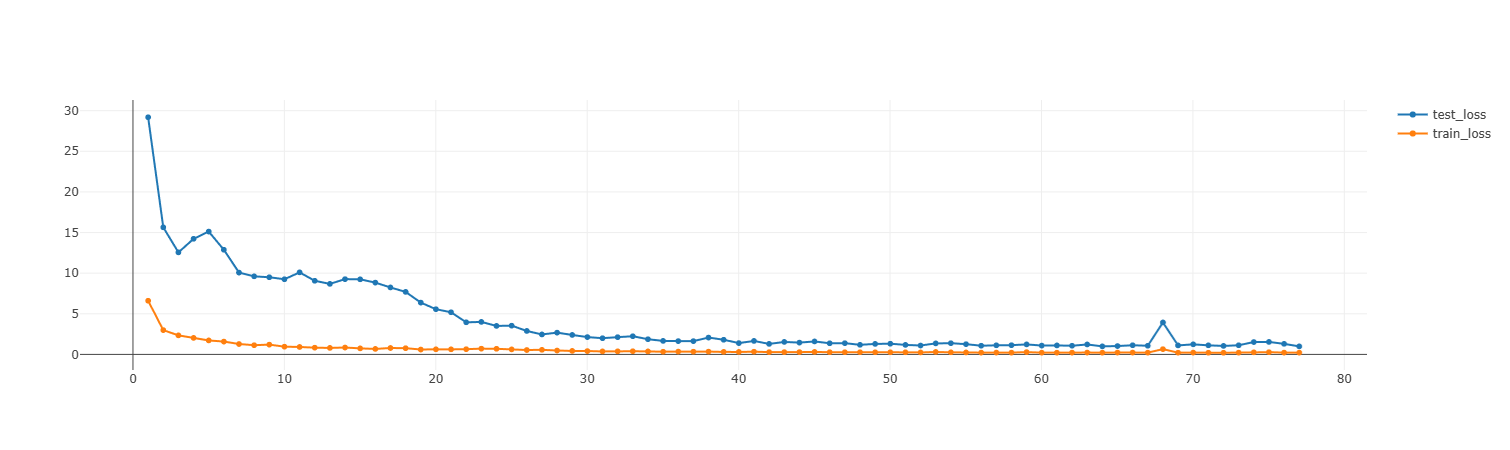

In [32]:
torch.manual_seed(42)
layers = nn.Sequential(
                        nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                        nn.ReLU(),
                        nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                        nn.Linear(115, 40),   
                        nn.ReLU(),
                        nn.Linear(40, 1)
                    )  
model = train_model(patience=20, delta=0.1, lr=1e-3, end_factor=0.5, total_iters=50, weight_decay=1e-5, layers=layers, 
                    run_series='conv2d_final')

Training
Test loss: 1.16567063331604
Train loss: 0.2065172642469406
Epochs: 66


Successfully registered model 'conv2d_final_4'.
Created version '1' of model 'conv2d_final_4'.


🏃 View run conv2d_final_4 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/0f9a9330806b4d16b7fc58e79c1233c7
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


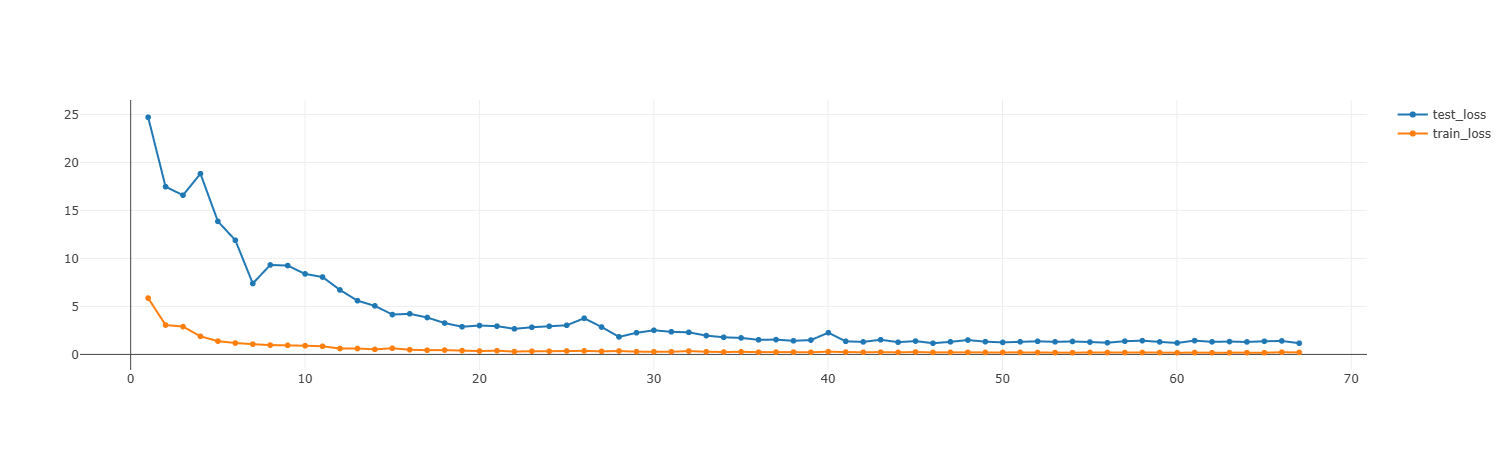

Weight decay 1e-4 showed most improvements. Now the model is taken to continue training with increased resources.

In [39]:
model = mlflow.pytorch.load_model('runs:/dad8865c7f894b22aa353ef5a9205313/model')
model = train_model(patience=50, delta=0.01, lr=5e-4, end_factor=0.2, total_iters=100, weight_decay=1e-4, model=model)

Training
Test loss: 0.8378551602363586
Train loss: 0.1644478142261505
Epochs: 93


Successfully registered model 'conv2d_final_5'.
Created version '1' of model 'conv2d_final_5'.


🏃 View run conv2d_final_5 at: http://192.168.0.174:8080/#/experiments/615000769780767661/runs/07a3b320c58d43ceac0fa917f7e25f14
🧪 View experiment at: http://192.168.0.174:8080/#/experiments/615000769780767661


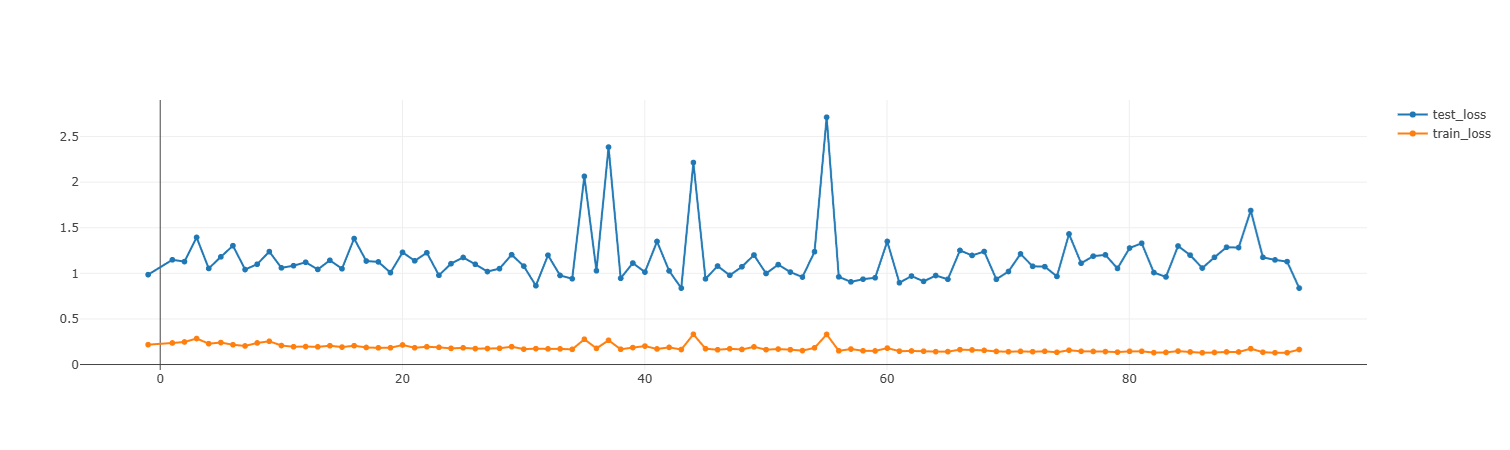

Saving champion model.

In [94]:
torch.save(model.state_dict(), 'model.pt')

### Predictions evaluation

Let's take a closer look at how the model performs on test and validation sets.

Test MSE:	 0.837855259555528
Test MAE:	 0.6455481394191372
Validation MSE:	 4.886217517498702
Validation MAE:	 1.166477463182076


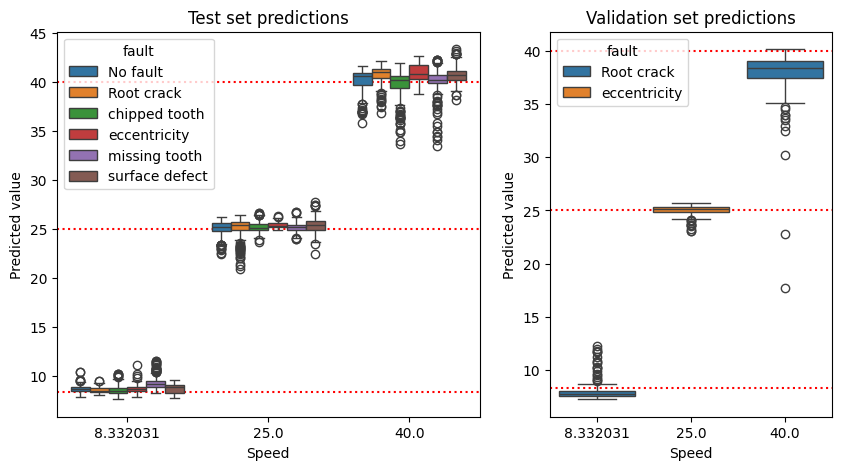

In [18]:
#data preparation
pred_test = df_test[['speed', 'load', 'fault']].copy()
pred_test.reset_index(inplace=True)
pred_valid = df_validation[['speed', 'load', 'fault']].copy()
pred_valid.reset_index(inplace=True)
#making predictions and storing them
model.eval()
with torch.no_grad():  
    pred = model(X_test_t).flatten().to('cpu')
    pred_test['pred_test'] = pred
    
    loss_fn = nn.MSELoss()
    loss = loss_fn(pred, torch.tensor(pred_test['speed'])).item()
    print('Test MSE:\t', loss)
    
    loss_fn = nn.L1Loss()
    loss = loss_fn(pred, torch.tensor(pred_test['speed'])).item()
    print('Test MAE:\t', loss)

    pred = model(X_validation_t).flatten().to('cpu')
    pred_valid['pred_val'] = pred
    
    loss_fn = nn.MSELoss()
    loss = loss_fn(pred, torch.tensor(pred_valid['speed'])).item()
    print('Validation MSE:\t', loss)
    
    loss_fn = nn.L1Loss()
    loss = loss_fn(pred, torch.tensor(pred_valid['speed'])).item()
    print('Validation MAE:\t', loss)
# plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": (.6, .4)})

for i in [0, 1]:
    ax[i].axhline(y=8.33, color='r', linestyle=':')
    ax[i].axhline(y=25, color='r', linestyle=':')
    ax[i].axhline(y=40, color='r', linestyle=':')
    ax[i].set_xlabel('Speed')
    ax[i].set_ylabel('Predicted value')
    
sns.boxplot(data=pred_test, x='speed', y='pred_test', hue='fault', ax=ax[0])
ax[0].set_title('Test set predictions')

sns.boxplot(data=pred_valid, x='speed', y='pred_val', hue='fault', ax=ax[1])
ax[1].set_title('Validation set predictions');

Predictions for test set lay close to target, with some amount of outliers. Root crack, missing tooth and eccentricity have worst results. Surprisingly good are results for surface defect, having most noisy spectrums of all defects.<br/>
As expected, performance on validation set is worse than on test. 8 and 25 rps have predictions nearly as good as for test dataset. 40 rps samples have bigger errors, which can be explained by not exactly well selected run as source and thus, result suffers from unrecognised features of this spectrum.

 ### Preprocessing function and testing

This is an example of making prediction with the model trained earlier on unprocessed data with format as in the original dataset.<br/>
Function prepare_data accepts pandas dataframes for each run an input tensor.

In [20]:
def prepare_data(runs, device='cpu'):
    if type(runs) is not list:  # enables the function to work with multiple runs or a single one
        runs = [runs]

    res = []

    for run in runs:  # FFT for selected readings(12500) and dropping unneeded spectrum parts
        freq1 = rfft(run.sort_values(by='time_x')['sensor1'].values, n=12500)[3:118]
        freq1 = np.abs(freq1)
        freq2 = rfft(run.sort_values(by='time_x')['sensor2'].values, n=12500)[3:118]
        freq2 = np.abs(freq2)

        res.append(np.concatenate((freq1, freq2)))
        
    res = pd.DataFrame(data=res, columns=[f's1_freq_{i}' for i in range(115)] + 
                                         [f's2_freq_{i}' for i in range(115)])

    ss = joblib.load('scaler.pkl')
    res = ss.transform(res)  # scaling resulting spectrums set

    res = torch.from_numpy(res.astype(np.float32)).to(device)  # creating input tensor
    res = torch.stack([res[:, :115], res[:, 115:]], dim=1)
    res = res.view(res.shape[0], 1, 2, 115)  # setting proper input shape

    return res

The code below reads all dataset files, separates each file into 6 runs(each file has data for 3 speeds and 2 loads) and stores them into a data frame.

In [21]:
runs = []
info = []

for file_name in ['eccentricity', 'missing_tooth', 'no_fault', 'root_crack', 'surface_fault', 'tooth_chipped_fault']:
    df = pd.read_csv(cur_dir + '//data//' + file_name + '.csv')  # loading each file
    
    for speed in sorted(df['speedSet'].unique()):    
        for load in sorted(df['load_value'].unique()):  
            runs.append(df[(df['load_value'] == load) & (df['speedSet'] == speed)].copy())            
            info.append([speed, load, df.loc[1, 'gear_fault_desc']])   

info = pd.DataFrame(info, columns=['speed', 'load', 'fault'])

print('Runs number:', len(runs))

Runs number: 36


This is simplified version NeuralNetwork, without functionality for training.

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                                    nn.Conv2d(1, 33, kernel_size=(2, 15), padding=(0, 7)),                     
                                    nn.ReLU(),
                                    nn.Conv2d(33, 1, kernel_size=(1, 1)), 
                                    nn.Linear(115, 40),   
                                    nn.ReLU(),
                                    nn.Linear(40, 1)
                                  ) 

    def forward(self, x):   
        return self.layers(x)

Actual model usage.

In [24]:
device = 'cpu'

model = CNN().to(device)  # creation of model class and sending it to selected device
model.load_state_dict(torch.load('model.pt', map_location=device))  # loading model's weights

model.eval()
with torch.no_grad():  
    pred = model(prepare_data(runs, device=device)).flatten().to('cpu')  # prediction
    info['pred'] = pred
    
    loss_fn = nn.MSELoss()
    loss = loss_fn(pred, torch.tensor(info['speed'])).item()
    print('MSE:\t', loss)

    loss_fn = nn.L1Loss()
    loss = loss_fn(pred, torch.tensor(info['speed'])).item()
    print('MAE:\t', loss)

MSE:	 1.488882434145334
MAE:	 0.9152151611116197


Despite the amount of runs in this test is greater than in validation set, these losses can not charecterise the model's performance, because almost all runs were partially exposed to the model during training.

### Conclusion

The best performing model reached MSE 4.8862 and MAE 1.1665(3.65% of prediction range) on validation set. All trained models and training process loss
values were stored in MLflow, enabling future enhancements.<br/>
During architecture selection and training, the trained models demonstrated high sensitivity to batch size. Best result, that was achieved with batch size 20(5 more, than used in final experiments series) was MSE 16, when best result of 100 batch size was MSE 49. This can be explained by low data diversity, specifically peaks configurations.